# ***תרגיל 5 של הפרוייקט***

**Load Data and Basic Setup**

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("/content/train-filtered_question_level.csv")

# Remove duplicate questions
df = df.drop_duplicates(subset=["question"], keep="first")

# Extract text and difficulty levels
texts = df["question"].astype(str).tolist()
levels = df["level"].tolist()


**Balancing Dataset (Undersampling to Minority Class)**

In [2]:
# import pandas as pd

# # 1. נגדיר את גודל היעד לפי המחלקה הקטנה ביותר (Hard)
# target_size = 15657

# # 2. נבצע דגימה מכל מחלקה בנפרד
# df_hard = df[df['level'] == 'hard']
# # כאן אנחנו לא עושים sample כי זה כבר הגודל שאנחנו רוצים

# df_medium_downsampled = df[df['level'] == 'medium'].sample(n=target_size, random_state=42)
# df_easy_downsampled = df[df['level'] == 'easy'].sample(n=target_size, random_state=42)

# # 3. נחבר את שלושתן יחד
# df_balanced = pd.concat([df_hard, df_medium_downsampled, df_easy_downsampled])

# # 4. נערבב את הדאטה (חשוב מאוד!)
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# # בדיקת תוצאה
# print("התפלגות חדשה:")
# print(df_balanced['level'].value_counts())

In [3]:
import pandas as pd

# 1. הגדרת גודל המדגם לכל קטגוריה (היפר-פרמטר של שלב הניסויים)
# התחלה עם 1000 מכל אחת עוזרת לבדיקה מהירה ("מתחילים בקטן" לפי ההוראות)
target_size = 7000

# 2. דגימה מאוזנת מכל הקטגוריות בבת אחת
# groupby מבטיח שנתייחס לכל רמת קושי בנפרד
df_balanced = df.groupby('level').apply(lambda x: x.sample(n=target_size, random_state=42)).reset_index(drop=True)

# 3. ערבוב הדאטה (Shuffle) - קריטי בלמידה עמוקה!
# כדי שה-Batch לא יכיל רק מחלקה אחת בזמן האימון, מה שיהרוס את הלמידה
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# בדיקת התפלגות כפי שנדרש בשלב ה-EDA ובניתוח הדאטה
print("התפלגות חדשה ומאוזנת:")
print(df_balanced['level'].value_counts())

התפלגות חדשה ומאוזנת:
level
easy      7000
medium    7000
hard      7000
Name: count, dtype: int64


/tmp/ipython-input-4281571597.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('level').apply(lambda x: x.sample(n=target_size, random_state=42)).reset_index(drop=True)


# **שלב 1**

# **א**

**Choosing Maximum Sequence Length (Documentation)**

In [4]:
!pip install tensorflow

In [5]:
import numpy as np
import torch
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. חילוץ הטקסטים
texts = df_balanced['question'].astype(str).tolist()

# 2. אתחול והתאמת הטוקנייזר על כל המילים (בלי הגבלה שרירותית של 20,000)
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# 3. הגדרת VOCAB_SIZE האמיתי (קריטי למטריצת ה-Embedding)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f"Actual Vocabulary size: {VOCAB_SIZE}")

# 4. המרה לרצפים וביצוע Padding
sequences = tokenizer.texts_to_sequences(texts)
MAX_LEN = int(np.percentile([len(seq) for seq in sequences], 95)) # אורך שחוסם 95% מהמשפטים
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')


Actual Vocabulary size: 36543


**Padding and Truncation**

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 1. הגדרת המילון (כפי שעשית)
label_dict = {'easy': 0, 'medium': 1, 'hard': 2}
y_integers = df_balanced['level'].map(label_dict).values

# 2. חלוקה מרובדת (Stratify) כדי לשמור על איזון באחוזים
# חלוקה ראשונה: מוציאים 15% לטסט סופי
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_integers,
    test_size=0.15,
    random_state=42,
    stratify=y_integers # מבטיח איזון
)

# חלוקה שנייה: פיצול היתרה לאימון וולידציה (15% מהסך הכל)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.176, # 0.15 / 0.85
    random_state=42,
    stratify=y_train_val # מבטיח איזון
)

print(f"Train size: {len(X_train)} | Val size: {len(X_val)} | Test size: {len(X_test)}")

Train size: 14708 | Val size: 3142 | Test size: 3150


In [7]:
# המרה ל-Tensors
# X הוא LongTensor כי הוא מכיל אינדקסים של מילים
# y הוא LongTensor כי CrossEntropyLoss מצפה לאינדקסים של מחלקות
train_ds = TensorDataset(torch.LongTensor(X_train), torch.LongTensor(y_train))
val_ds   = TensorDataset(torch.LongTensor(X_val), torch.LongTensor(y_val))
test_ds  = TensorDataset(torch.LongTensor(X_test), torch.LongTensor(y_test))

# יצירת Loaders
# shuffle=True רק באימון כדי שהמודל לא ילמד את סדר השאלות
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print("PyTorch DataLoaders are ready!")

PyTorch DataLoaders are ready!


# **ב**

**ניסוי 1**

In [9]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 42.6 MB/s eta 0:00:00


In [10]:
from gensim.models import Word2Vec

# הכנת המשפטים לאימון (רשימה של רשימות מילים)
sentences_for_w2v = [text.split() for text in texts]

# אימון Word2Vec - לומד את הקשרים בין המילים בדאטה שלך
w2v_model = Word2Vec(sentences=sentences_for_w2v, vector_size=100, window=5, min_count=1, sg=1)

# יצירת מטריצת המשקולות (הגשר בין Word2Vec ל-PyTorch)
EMBED_DIM = 100
# VOCAB_SIZE צריך להיות שווה ל- len(tokenizer.word_index) + 1
embedding_matrix = torch.zeros((VOCAB_SIZE, EMBED_DIM))

for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        if word in w2v_model.wv:
            embedding_matrix[i] = torch.tensor(w2v_model.wv[word].copy())
        else:
            # מילים שלא קיימות ב-W2V מקבלות ערך אקראי קטן
            embedding_matrix[i] = torch.randn(EMBED_DIM) * 0.1

EMBED_MAT = embedding_matrix # נשמור את זה בשם ברור לניסויים

In [11]:
class DifficultyModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, weights=None, is_frozen=False):
        super().__init__()
        if weights is not None:
            self.embedding = torch.nn.Embedding.from_pretrained(weights, freeze=is_frozen)
        else:
            self.embedding = torch.nn.Embedding(vocab_size, embed_dim)

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(embed_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(64, 3) # 3 קטגוריות
        )

    def forward(self, x):
        x = self.embedding(x).mean(dim=1) # Pooling
        return self.classifier(x)

def train_model(model, train_loader, val_loader, epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for texts_batch, labels_batch in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(texts_batch), labels_batch)
            loss.backward()
            optimizer.step()

    # חישוב דיוק סופי
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for texts_batch, labels_batch in val_loader:
            _, predicted = torch.max(model(texts_batch), 1)
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()
    return 100 * correct / total

**Embedding Layer מאומן מאפס**

In [12]:
model_scratch = DifficultyModel(VOCAB_SIZE, EMBED_DIM)
acc_scratch = train_model(model_scratch, train_loader, val_loader)
print(f"Accuracy (Scratch): {acc_scratch:.2f}%")

Accuracy (Scratch): 49.68%


**The Frozen model**

In [13]:
# ניסוי 2א: Word2Vec קפוא (Frozen)
model_frozen = DifficultyModel(VOCAB_SIZE, EMBED_DIM, weights=embedding_matrix, is_frozen=True)
acc_frozen = train_model(model_frozen, train_loader, val_loader)
print(f"Accuracy (W2V Frozen): {acc_frozen:.2f}%")

Accuracy (W2V Frozen): 50.99%


**Fine-tuned**

In [14]:
# ניסוי 2ב: Word2Vec מכוונן (Fine-tuned)
model_tuned = DifficultyModel(VOCAB_SIZE, EMBED_DIM, weights=embedding_matrix, is_frozen=False)
acc_tuned = train_model(model_tuned, train_loader, val_loader)
print(f"Accuracy (W2V Fine-tuned): {acc_tuned:.2f}%")

Accuracy (W2V Fine-tuned): 49.65%


# **שלב 2**

**Basic Settings**

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. ארכיטקטורת המודל
class FlexibleModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers,
                 model_type='LSTM', bidirectional=False, dropout_p=0.0,
                 embedding_matrix=None, is_frozen=False):
        super(FlexibleModel, self).__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = not is_frozen
        else:
            self.embedding.weight.requires_grad = True

        rnn_dropout = dropout_p if n_layers > 1 else 0.0
        if model_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, n_layers, batch_first=True,
                              bidirectional=bidirectional, dropout=rnn_dropout)
        else:
            self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True,
                               bidirectional=bidirectional, dropout=rnn_dropout)

        num_directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * num_directions, output_dim)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        if isinstance(hidden, tuple): hidden = hidden[0]
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]
        return self.fc(hidden)

# 2. פונקציית אימון עם Patience
def run_experiment(model, train_loader, val_loader, epochs=5, lr=0.001, patience=3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss, correct = 0.0, 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        acc = correct / len(val_loader.dataset)
        history['train_loss'].append(total_train_loss / len(train_loader))
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(acc)

        print(f"Epoch {epoch+1}/{epochs} | Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(torch.load('best_model.pt'))
    return history

# 3. הערכת ביצועים - כולל מטריצת הבלבול הויזואלית!
def print_evaluation_section_c(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in loader:
            outputs = model(texts.to(device))
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    # הדפסת הדו"ח
    print("\n" + "="*30)
    print(classification_report(all_labels, all_preds, target_names=['Easy', 'Medium', 'Hard']))

    # ציור המטריצה
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Easy', 'Medium', 'Hard'],
                yticklabels=['Easy', 'Medium', 'Hard'])
    plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_training_history(history, model_name="Model"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.legend(); plt.title(f"{model_name} - Loss")
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.legend(); plt.title(f"{model_name} - Accuracy")
    plt.show()

def print_misclassifications(model, dataloader, device, tokenizer, label_map, target_true='Medium', target_pred='Hard', num_examples=5):
    model.eval()
    results = []
    inv_label_map = {v: k for k, v in label_map.items()}
    true_idx = inv_label_map[target_true]
    pred_idx = inv_label_map[target_pred]

    def decode_text(text_tensor, tokenizer):
        return " ".join([tokenizer.index_word.get(i.item(), "") for i in text_tensor if i.item() > 0]).strip()

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            preds = model(texts).argmax(1)
            for i in range(len(labels)):
                if labels[i].item() == true_idx and preds[i].item() == pred_idx:
                    results.append(decode_text(texts[i], tokenizer))
                if len(results) >= num_examples: break
            if len(results) >= num_examples: break
    print(f"\n--- דוגמאות לטעות ({target_true} -> {target_pred}) ---")
    for j, text in enumerate(results): print(f"{j+1}) {text}\n")

In [24]:
import torch

def decode_text(text_tensor, tokenizer):
    # הפיכת וקטור מספרים חזרה לטקסט קריא
    index_to_word = tokenizer.index_word
    words = [index_to_word.get(i.item(), "") for i in text_tensor if i.item() > 0]
    return " ".join(words).strip()

def print_misclassifications(model, dataloader, device, tokenizer, label_map, target_true='Medium', target_pred='Hard', num_examples=5):
    model.eval()
    results = []
    inv_label_map = {v: k for k, v in label_map.items()}
    true_idx = inv_label_map[target_true]
    pred_idx = inv_label_map[target_pred]

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds = outputs.argmax(1)

            for i in range(len(labels)):
                if labels[i].item() == true_idx and preds[i].item() == pred_idx:
                    original_text = decode_text(texts[i], tokenizer)
                    results.append(original_text)
                if len(results) >= num_examples: break
            if len(results) >= num_examples: break

    print(f"\n--- דוגמאות של {target_true} שסווגו בטעות כ-{target_pred} ---")
    if not results:
        print("לא נמצאו דוגמאות כאלו בניסוי הנוכחי.")
    else:
        for j, text in enumerate(results):
            print(f"{j+1}) {text}\n")

**RNN - Regular embedding**

--- מריץ ניסוי: RNN | BS=32 | Frozen=True ---
Epoch 1/10 | Val Loss: 1.0126 | Val Acc: 0.4192
Epoch 2/10 | Val Loss: 1.0658 | Val Acc: 0.3845
Epoch 3/10 | Val Loss: 1.0236 | Val Acc: 0.4064
Epoch 4/10 | Val Loss: 1.0597 | Val Acc: 0.3902
Early stopping at epoch 4

              precision    recall  f1-score   support

        Easy       0.98      0.27      0.43      1050
      Medium       0.00      0.00      0.00      1050
        Hard       0.37      1.00      0.54      1050

    accuracy                           0.42      3150
   macro avg       0.45      0.42      0.32      3150
weighted avg       0.45      0.42      0.32      3150



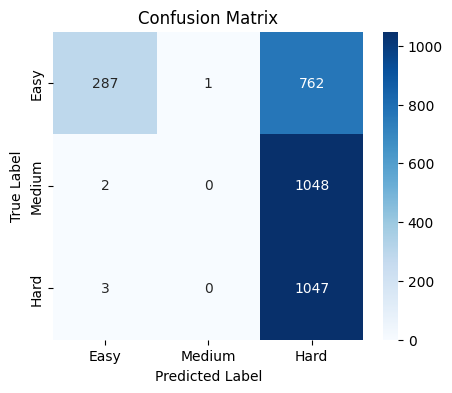

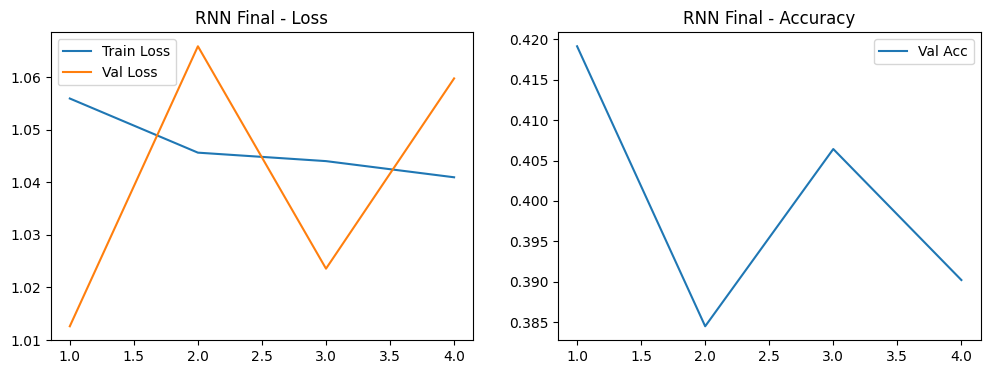


--- דוגמאות לטעות (Medium -> Hard) ---
1) who wrote the screenplay for director barbe schroeder's palme d'or winning movie

2) herieth paul is a tanzanian fashion model who has walked for an american fashion designer who directed what 2009 film

3) what year was the actor born that stared in a 1985 american comedy head office

4) piano concerto was premiered by a pianist who has what ethnicity

5) what primarily competed with nintendo 64 and sega staurn has a horror themed adventure game published by jaleco in 1999



In [42]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.0
LEARNING_RATE = 0.001
BATCH_SIZE = 32           # <--- הנה הוא! נסי 32, 64 או 128
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 1
PATIENCE = 3
IS_FROZEN = True          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    #embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    #is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)

--- מריץ ניסוי: RNN | BS=64 | Frozen=True ---
Epoch 1/10 | Val Loss: 1.0325 | Val Acc: 0.4074
Epoch 2/10 | Val Loss: 0.9819 | Val Acc: 0.4570
Epoch 3/10 | Val Loss: 0.9851 | Val Acc: 0.4510
Epoch 4/10 | Val Loss: 0.9804 | Val Acc: 0.4526
Epoch 5/10 | Val Loss: 0.9748 | Val Acc: 0.4558
Epoch 6/10 | Val Loss: 0.9694 | Val Acc: 0.4637
Epoch 7/10 | Val Loss: 0.9903 | Val Acc: 0.4548
Epoch 8/10 | Val Loss: 0.9782 | Val Acc: 0.4545
Epoch 9/10 | Val Loss: 0.9712 | Val Acc: 0.4618
Early stopping at epoch 9

              precision    recall  f1-score   support

        Easy       0.74      0.44      0.55      1050
      Medium       0.35      0.04      0.07      1050
        Hard       0.38      0.88      0.53      1050

    accuracy                           0.45      3150
   macro avg       0.49      0.45      0.38      3150
weighted avg       0.49      0.45      0.38      3150



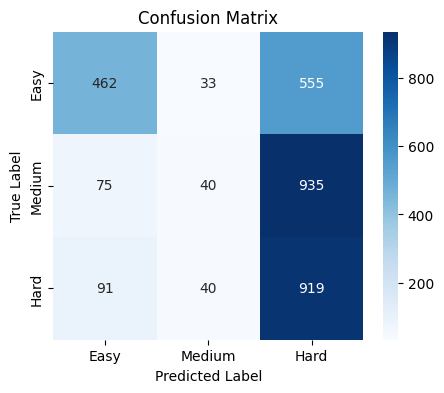

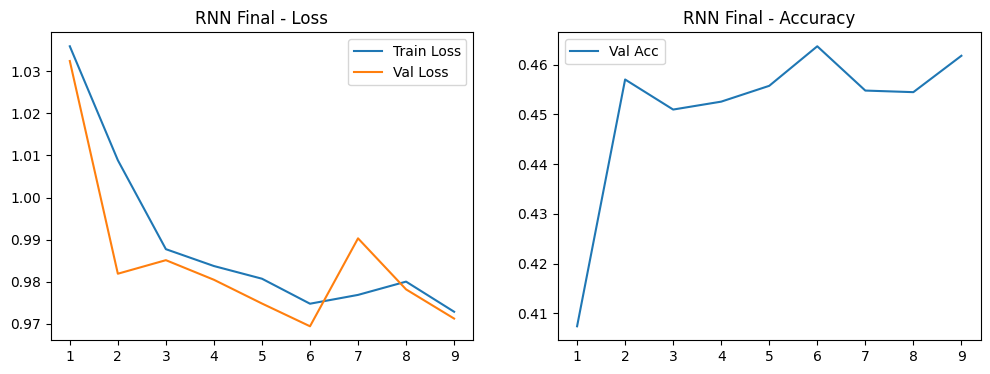


--- דוגמאות לטעות (Medium -> Hard) ---
1) who wrote the screenplay for director barbe schroeder's palme d'or winning movie

2) herieth paul is a tanzanian fashion model who has walked for an american fashion designer who directed what 2009 film

3) what year was the actor born that stared in a 1985 american comedy head office

4) piano concerto was premiered by a pianist who has what ethnicity

5) what primarily competed with nintendo 64 and sega staurn has a horror themed adventure game published by jaleco in 1999



In [52]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.2
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 3
PATIENCE = 3
IS_FROZEN = True          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    #embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    #is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)